In [1]:
%reload_ext lab_black
%matplotlib inline

from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [70]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last_date = (
    session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
)
# last_date

last_12_mo = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)
# last_12_mo

prcp_stats = (
    session.query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date >= last_12_mo)
    .group_by(Measurement.date)
    .all()
)
prcp_stats[:10]

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05)]

In [25]:
# Precipitation Dataframe
prcp_df = pd.DataFrame(prcp_stats, columns=["Date", "Precipitation"])
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


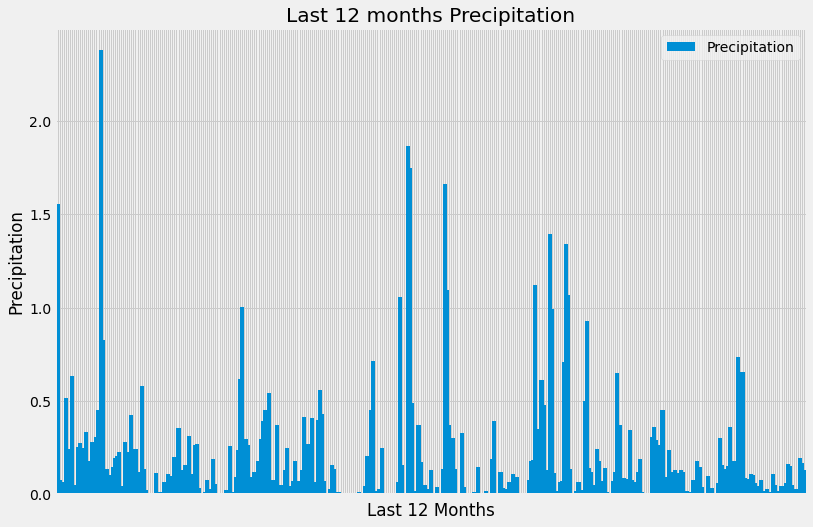

In [31]:
# Precipitation Bar Chart
ax = prcp_df.plot(kind="bar", figsize=(12, 8), width=2)
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Last 12 Months")
plt.ylabel("Precipitation")
plt.title("Last 12 months Precipitation")
plt.grid(True)
plt.savefig("images/prcp.png")
plt.show()

In [32]:
# Precipitation summary statistics
prcp_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [33]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.id).count()
stations

9

In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

count_ = func.count(Measurement.id)

most_active_stations = (
    session.query(Measurement.station, count_)
    .group_by(Measurement.station)
    .order_by(count_.desc())
    .all()
)
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?

most_active_station = most_active_stations[:1][0][0]

stats = (
    session.query(
        Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station)
    .group_by(Measurement.station)
    .all()
)
stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_stats = (
    session.query(Measurement.station, Measurement.tobs)
    .filter(Measurement.date >= last_12_mo)
    .filter(Measurement.station == most_active_station)
    .all()
)
tobs_stats[:10]

[('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0)]

In [41]:
# Tobs Dataframe
tobs_df = pd.DataFrame(tobs_stats)
tobs_df.set_index("station", inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


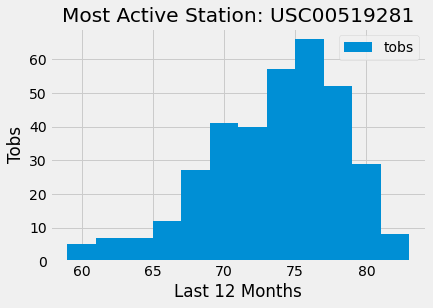

In [42]:
# Tobs Histogram
tobs_df.plot.hist(bins=12)
plt.xlabel("Last 12 Months")
plt.ylabel("Tobs")
plt.title("Most Active Station: " + most_active_stations[:1][0][0])
plt.grid(True)
plt.savefig("images/tobs.png")
plt.show()

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )

# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

trip_temp = calc_temps("2017-05-05", "2017-05-31")
trip_temp

[(66.0, 75.16556291390728, 87.0)]

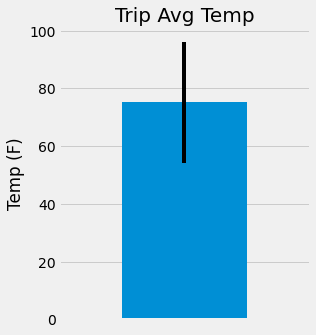

In [56]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp_df = pd.DataFrame(trip, columns=["Min Temp", "Avg Temp", "Max Temp"])
avg_temp = trip_temp_df["Avg Temp"]
min_max_temp = trip_temp_df.iloc[0]["Max Temp"] - trip_temp_df.iloc[0]["Min Temp"]
avg_temp.plot(kind="bar", yerr=min_max_temp, figsize=(4, 5))
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(True)
plt.savefig("images/trip.png")
plt.show()

In [84]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sum_prcp_ = func.sum(Measurement.prcp)

prcp_trip = (
    session.query(
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        sum_prcp_,
    )
    .join(Station, Measurement.station == Station.station)
    .filter(Measurement.date >= "2012-03-05")
    .filter(Measurement.date <= "2012-03-05")
    .group_by(Measurement.station)
    .order_by(sum_prcp_.desc())
    .all()
)
prcp_trip

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  6.24),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.71),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.37),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.71),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.08),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.92),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.7),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`